In [1]:
!pip install librosa


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install opencv-python


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import librosa.display
import cv2

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample

ModuleNotFoundError: No module named 'lightgbm'

In [2]:
accuracy = []
precision = []
recall = []
fscore = []

model_folder = "model"

In [3]:

def remove_noise(audio, sr):
    noise_profile = audio[:int(0.5 * sr)]
    noise_reduced_audio = librosa.effects.remix(audio, intervals=librosa.effects.split(audio, top_db=20))
    return noise_reduced_audio

In [4]:
def load_audio_with_features(path, categories, model_folder):
    X_file = os.path.join(model_folder, "X.npy")
    Y_file = os.path.join(model_folder, "Y.npy")

    if os.path.exists(X_file) and os.path.exists(Y_file):
        print(f"Loading cached data from {model_folder}")
        X = np.load(X_file)
        Y = np.load(Y_file)
    else:
        print(f"Path does not exist: {path}" if not os.path.exists(path) else "Processing directory")
        X = []
        Y = []

        for root, dirs, files in os.walk(path):
            print(f"Processing root: {root}")
            for file in files:
                name = os.path.basename(root)
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    try:
                        y, sr = librosa.load(file_path, sr=None)  # Load the audio file

                        # Extracting 10 different features
                        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30).T, axis=0)
                        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
                        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
                        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
                        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
                        rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
                        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
                        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
                        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
                        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)

                        # Concatenating features into a single vector
                        feature_vector = np.hstack([
                            mfccs, chroma, mel, spectral_contrast, tonnetz,
                            rms, spectral_bandwidth, spectral_centroid, spectral_rolloff, zero_crossing_rate
                        ])

                        X.append(feature_vector)
                        if name in categories:
                            Y.append(categories.index(name))
                        else:
                            print(f"Category {name} not in categories list.")
                    except Exception as e:
                        print(f"Skipping {file_path}, error reading file: {e}")

        X = np.array(X)
        Y = np.array(Y)
        os.makedirs(model_folder, exist_ok=True)  # Ensure the directory exists
        np.save(X_file, X)
        np.save(Y_file, Y)

    return X, Y

In [5]:
def Upload_Dataset():
    global filename, categories
    filename = "dataset"
    categories = [d for d in os.listdir(filename) if os.path.isdir(os.path.join(filename, d))]
    print('Dataset loaded')
    print("Classes found in dataset:", categories)

In [18]:
def Preprocess_Dataset():
    global X, Y, filename, categories, df

    path = filename
    X, Y = load_audio_with_features(path, categories, model_folder)

    print(f"Preprocessing and MFCC Feature Extraction completed on Dataset: {filename}")
    print(f"Input MFCC Feature Set Size: {X.shape}")

    X_list = X.tolist()
    Y_list = Y.tolist()
    df = pd.DataFrame({'X': X_list, 'Y': Y_list})

    # Plot the counts of each category
    category_counts = {category: len(os.listdir(os.path.join(path, category))) for category in categories}
    df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

    plt.figure(figsize=(10, 6))
    plt.bar(df_counts['Category'], df_counts['Count'], color='skyblue')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Number of Sounds per Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [7]:
def Train_Test_Splitting():
    global X, Y
    global x_train, y_train, x_test, y_test

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    # Display information about the dataset
    print("Total records found in dataset:", X.shape[0])
    print("Total records found in dataset to train:", x_train.shape[0])
    print("Total records found in dataset to test:", x_test.shape[0])

In [8]:
def Calculate_Metrics(algorithm, predict, y_test):
    global categories

    a = accuracy_score(y_test, predict) * 100
    p = precision_score(y_test, predict, average='macro') * 100
    r = recall_score(y_test, predict, average='macro') * 100
    f = f1_score(y_test, predict, average='macro') * 100

    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)

    print(f"{algorithm} Accuracy  : {a}")
    print(f"{algorithm} Precision : {p}")
    print(f"{algorithm} Recall    : {r}")
    print(f"{algorithm} FScore    : {f}")

    conf_matrix = confusion_matrix(y_test, predict)
    CR = classification_report(y_test, predict, target_names=categories)

    print(f"{algorithm} Classification Report:\n{CR}\n")

    plt.figure(figsize=(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels=categories, yticklabels=categories, annot=True, cmap="viridis", fmt="g")
    ax.set_ylim([0, len(categories)])
    plt.title(f"{algorithm} Confusion Matrix") 
    plt.ylabel('True Class') 
    plt.xlabel('Predicted Class') 
    plt.show()

In [9]:
def existing_classifier():
    
    global x_train,y_train,x_test,y_test,mlpc1

    path = 'model/MLPClassifier'
    if(os.path.exists(path)):
        mlpc1 = joblib.load(path) 
    else:
        mlpc1 = MLPClassifier()
        mlpc1.fit(x_train, y_train)
        joblib.dump(mlpc1,path)
    y_pred = mlpc1.predict(x_test)
    Calculate_Metrics("Existing MLP Classifier", y_pred, y_test)

In [10]:
def existing_classifier1():
    
    global x_train,y_train,x_test,y_test
    
    path = 'model/KNN'
    if(os.path.exists(path)):
        mlpc = joblib.load(path) 
    else:
        mlpc = KNeighborsClassifier()
        mlpc.fit(x_train, y_train)
        joblib.dump(mlpc,path)
    y_pred = mlpc.predict(x_test)
    Calculate_Metrics("Existing KNN Classifier", y_pred, y_test)


In [11]:
def existing_classifier3():
    global x_train,y_train,x_test,y_test

    path = 'model/LRC'
    if(os.path.exists(path)):
        mlpc = joblib.load(path) 
    else:
        mlpc = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')
        mlpc.fit(x_train, y_train)
        joblib.dump(mlpc,path)
    y_pred = mlpc.predict(x_test)
    Calculate_Metrics("Existing LRC", y_pred, y_test)

In [12]:
def proposed_classifier():
    global X_train, X_test, y_train, y_test,lgbm

    path = 'model/LGBMClassifier'
    if(os.path.exists(path)):
        lgbm = joblib.load(path) 
    else:
        lgbm = LGBMClassifier()
        lgbm.fit(X_train, y_train)
        joblib.dump(lgbm,path)
    y_pred = lgbm.predict(X_test)
    Calculate_Metrics("Proposed Light Gradiant Boosting Classifier", y_pred, y_test)


In [13]:
def preprocess_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=None)

        # Extracting 10 different features
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=30).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).T, axis=0)
        rms = np.mean(librosa.feature.rms(y=audio).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr).T, axis=0)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr).T, axis=0)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr).T, axis=0)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)

        # Concatenating features into a single vector
        feature_vector = np.hstack([
            mfccs, chroma, mel, spectral_contrast, tonnetz,
            rms, spectral_bandwidth, spectral_centroid, spectral_rolloff, zero_crossing_rate
        ])

        return feature_vector

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [34]:
def Prediction(filename):
    global mlpc1, categories

    X_new = preprocess_audio(filename)
    X_new = X_new.reshape(1, -1)

    prediction = mlpc1.predict(X_new)
    predicted_category = categories[prediction[0]]

    print(f"Predicted Outcome From Test Audio is: {predicted_category}\n")

    # Load audio file
    y, sr = librosa.load(filename, sr=None)

    # Create a waveplot
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f"Predicted: {predicted_category}")

    # Display the waveplot
    plt.show()

In [16]:
Upload_Dataset()

Dataset loaded
Classes found in dataset: ['air_conditioner', 'car_horn', 'children_playing', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren']


Loading cached data from model
Preprocessing and MFCC Feature Extraction completed on Dataset: dataset
Input MFCC Feature Set Size: (735, 188)


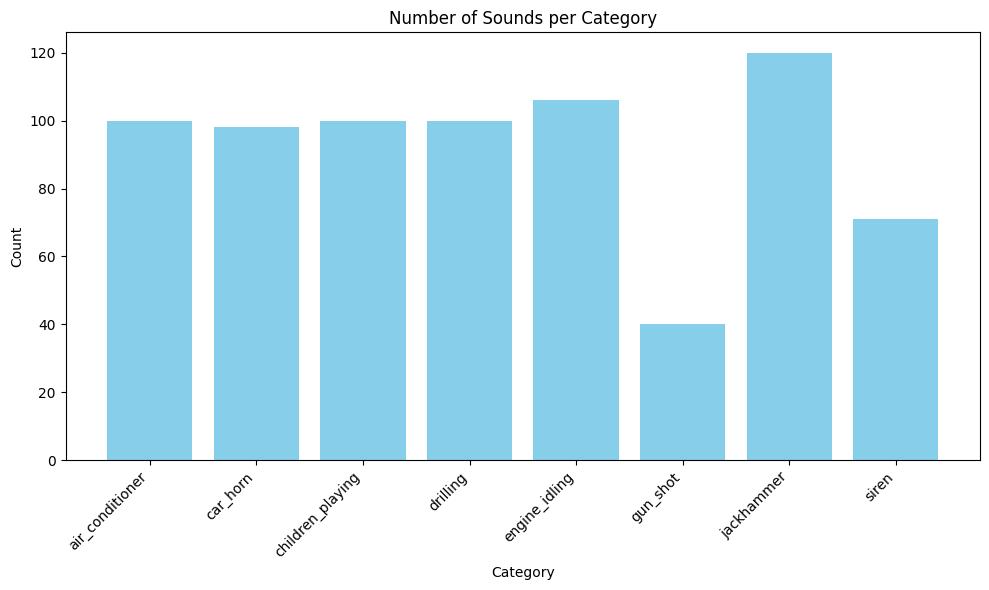

In [19]:
Preprocess_Dataset()

In [20]:
Train_Test_Splitting()

Total records found in dataset: 735
Total records found in dataset to train: 588
Total records found in dataset to test: 147


Existing MLP Classifier Accuracy  : 92.51700680272108
Existing MLP Classifier Precision : 93.27286255411255
Existing MLP Classifier Recall    : 90.77870046620046
Existing MLP Classifier FScore    : 91.71427693283192
Existing MLP Classifier Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.95      1.00      0.98        20
        car_horn       0.94      1.00      0.97        15
children_playing       0.92      0.96      0.94        24
        drilling       0.85      0.85      0.85        20
   engine_idling       1.00      0.91      0.95        22
        gun_shot       1.00      0.75      0.86         8
      jackhammer       0.89      0.96      0.93        26
           siren       0.91      0.83      0.87        12

        accuracy                           0.93       147
       macro avg       0.93      0.91      0.92       147
    weighted avg       0.93      0.93      0.92       147




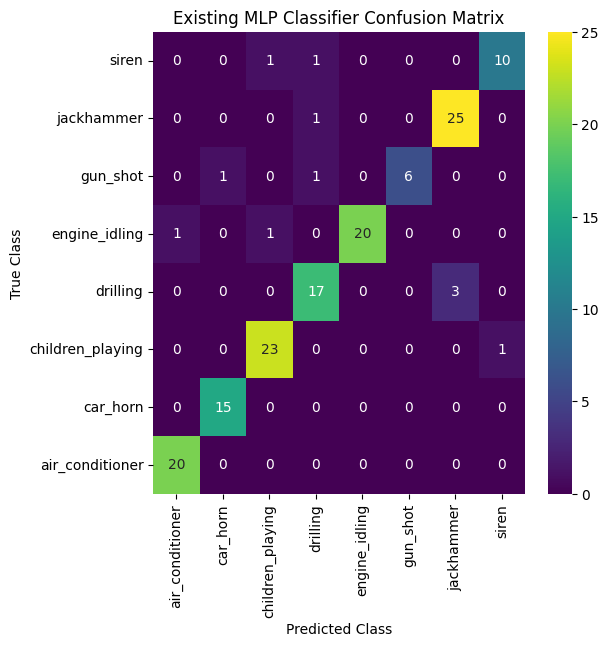

In [21]:
existing_classifier()

Existing KNN Classifier Accuracy  : 76.19047619047619
Existing KNN Classifier Precision : 77.33326300136645
Existing KNN Classifier Recall    : 72.51165501165502
Existing KNN Classifier FScore    : 72.78613841113841
Existing KNN Classifier Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.83      1.00      0.91        20
        car_horn       0.55      0.80      0.65        15
children_playing       0.58      0.58      0.58        24
        drilling       0.92      0.60      0.73        20
   engine_idling       0.77      0.77      0.77        22
        gun_shot       0.67      0.25      0.36         8
      jackhammer       0.86      0.96      0.91        26
           siren       1.00      0.83      0.91        12

        accuracy                           0.76       147
       macro avg       0.77      0.73      0.73       147
    weighted avg       0.78      0.76      0.75       147




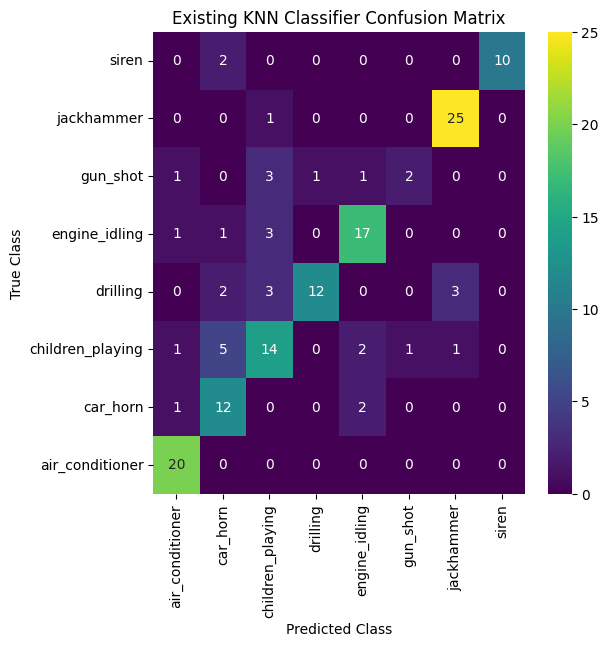

In [22]:
existing_classifier1()

Existing LRC Accuracy  : 83.6734693877551
Existing LRC Precision : 88.02597369861435
Existing LRC Recall    : 82.6486013986014
Existing LRC FScore    : 84.34843595557882
Existing LRC Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.69      1.00      0.82        20
        car_horn       1.00      0.87      0.93        15
children_playing       0.80      0.83      0.82        24
        drilling       0.84      0.80      0.82        20
   engine_idling       0.89      0.73      0.80        22
        gun_shot       1.00      0.75      0.86         8
      jackhammer       0.82      0.88      0.85        26
           siren       1.00      0.75      0.86        12

        accuracy                           0.84       147
       macro avg       0.88      0.83      0.84       147
    weighted avg       0.86      0.84      0.84       147




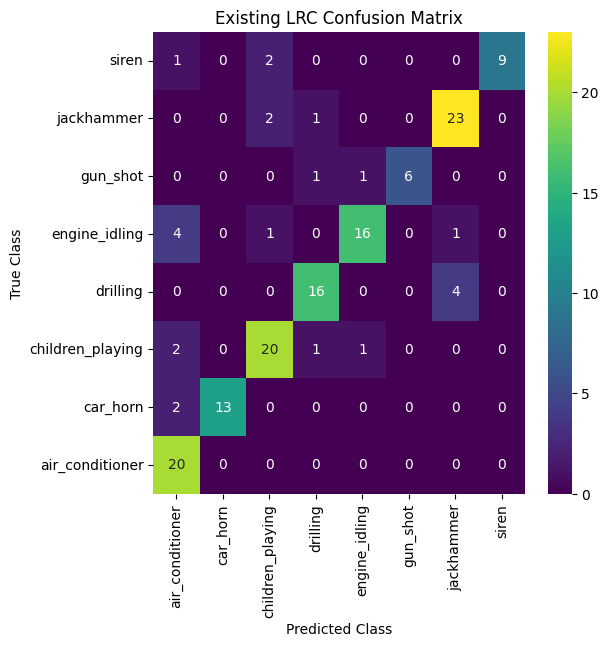

In [24]:
existing_classifier3()

In [26]:
from imblearn.over_sampling import SMOTE

def SMOTE_databalancing():
    global df, Y, X_train, X_test, y_train, y_test

    df_resampled = resample(df, replace=True, n_samples=4000, random_state=42)
    X_new = df_resampled['X'].tolist()
    Y_new = df_resampled['Y'].tolist()

    smote = SMOTE(random_state=42)
    X_resampled, Y_resampled = smote.fit_resample(X_new, Y_new)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.20, random_state=44)

    print("Data balancing completed using SMOTE.")
    print(f"Original dataset size: {len(Y)}")
    print(f"Resampled dataset size: {len(Y_resampled)}")

    plt.figure(figsize=(12, 5))

    # Plot count distribution before balancing
    plt.subplot(1, 2, 1)
    unique_before, counts_before = np.unique(Y, return_counts=True)
    sns.barplot(x=unique_before, y=counts_before)
    plt.title('Class Distribution Before Data Balancing')
    for index, value in enumerate(counts_before):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Plot count distribution after balancing
    plt.subplot(1, 2, 2)
    unique_after, counts_after = np.unique(Y_resampled, return_counts=True)
    sns.barplot(x=unique_after, y=counts_after)
    plt.title('Class Distribution After Data Balancing')
    for index, value in enumerate(counts_after):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Data balancing completed using SMOTE.
Original dataset size: 735
Resampled dataset size: 5512


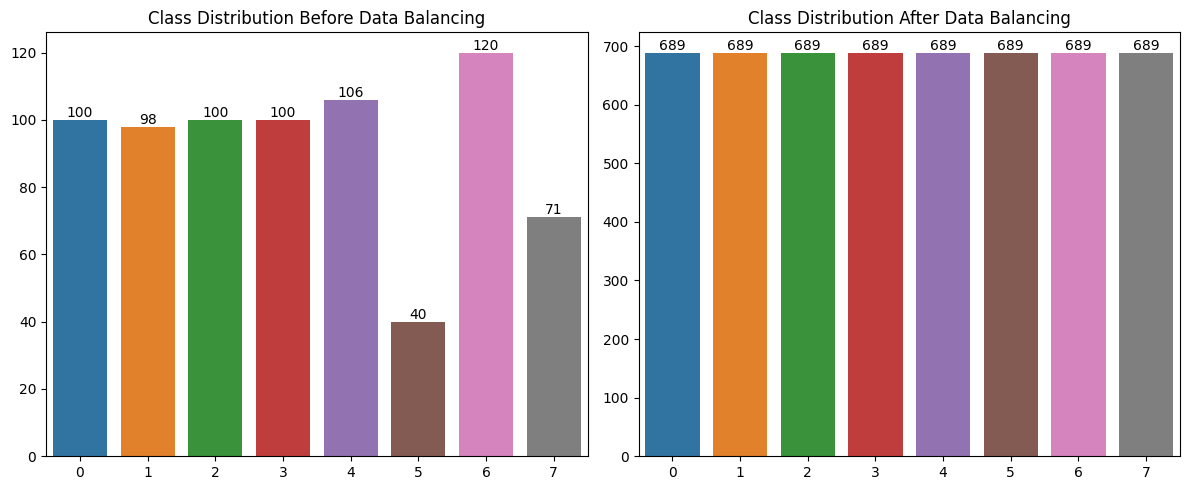

In [28]:
SMOTE_databalancing()

Proposed Light Gradiant Boosting Classifier Accuracy  : 99.909338168631
Proposed Light Gradiant Boosting Classifier Precision : 99.90942028985508
Proposed Light Gradiant Boosting Classifier Recall    : 99.91666666666667
Proposed Light Gradiant Boosting Classifier FScore    : 99.91273943447855
Proposed Light Gradiant Boosting Classifier Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       1.00      1.00      1.00       146
        car_horn       1.00      0.99      1.00       150
children_playing       1.00      1.00      1.00       138
        drilling       0.99      1.00      1.00       137
   engine_idling       1.00      1.00      1.00       148
        gun_shot       1.00      1.00      1.00       143
      jackhammer       1.00      1.00      1.00       114
           siren       1.00      1.00      1.00       127

        accuracy                           1.00      1103
       macro avg       1.00      1.00      1.00      1103

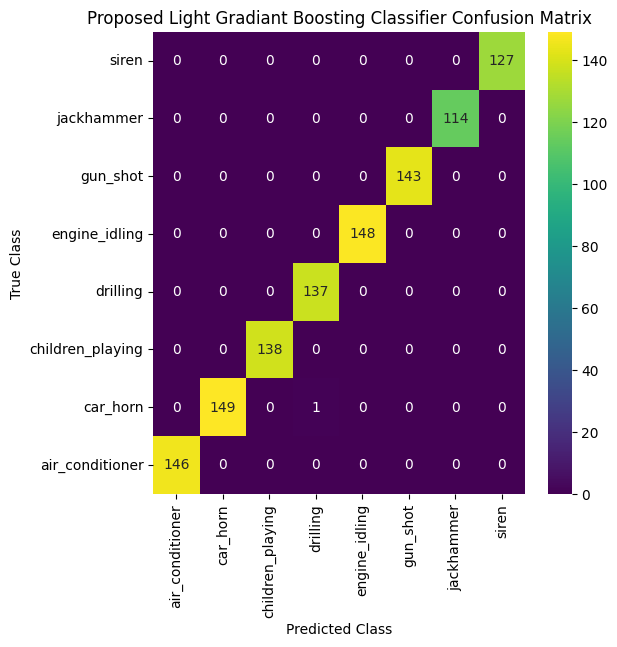

In [29]:
proposed_classifier()

c:\users\asus\python376\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=565
  return f(*args, **kwargs)
c:\users\asus\python376\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=283
  return f(*args, **kwargs)


Predicted Outcome From Test Audio is: gun_shot



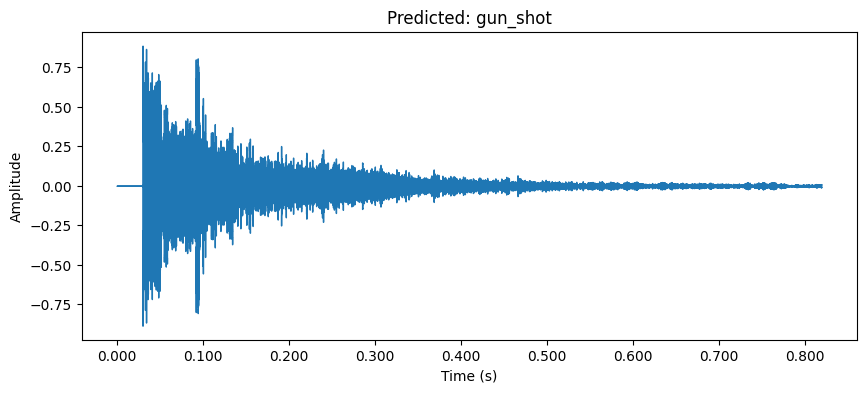

In [35]:
filename=r"test_data\7066-6-0-0.wav"
Prediction(filename)